In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from pathlib import Path

In [9]:
ann_data = pd.read_csv("crop_stats.csv", index_col=0)

In [10]:
ann_mask = (ann_data['ann_h'] > 0) & (ann_data['ann_w'] > 0)
ann_data = ann_data[ann_mask]

In [11]:
ann_data['img_dim'] = np.sqrt(ann_data['img_w'] * ann_data['img_h'])
ann_data['ann_dim'] = np.sqrt(ann_data['ann_w'] * ann_data['ann_h'])
ann_data['ratio'] = np.clip(ann_data['ann_dim'] / ann_data['img_dim'], a_min=0, a_max=1)

In [12]:
print("BIN 1 (<1/16): " + str(pd.value_counts(ann_data['ratio'] < 2**-4)[True]))
print("BIN 2 (1/16-1/8): " + str(pd.value_counts((ann_data['ratio'] > 2**-4) & (ann_data['ratio'] < 2**-3))[True]))
print("BIN 3 (1/8-1/4): " + str(pd.value_counts((ann_data['ratio'] > 2**-3) & (ann_data['ratio'] < 2**-2))[True]))
print("BIN 4 (>1/4): " + str(pd.value_counts(ann_data['ratio'] > 2**-2)[True]))

BIN 1 (<1/16): 24966
BIN 2 (1/16-1/8): 24974
BIN 3 (1/8-1/4): 8613
BIN 4 (>1/4): 8511


In [112]:
nbins = 100
logbins = np.logspace(base=2, start=-8, stop=0, num=nbins)

In [ ]:
ann_data['cat'] = pd.cut(np.log2(ann_data['ratio']), [-8, -4, -3, -2, 0], labels=range(4))
n, bins, patches = plt.hist(ann_data['ratio'], bins=logbins)
plt.xscale('log', base=2)
cm = plt.cm.get_cmap('tab10')
counts = [0, 0, 0, 0]

for i in range(nbins-1):
    logx = (np.log2(logbins[i]) + np.log2(logbins[i+1])) / 2
    if logx > -2:
        plt.setp(patches[i], 'facecolor', cm(0))
        counts[0] += n[i]
    elif logx > -3:
        plt.setp(patches[i], 'facecolor', cm(1))
        counts[1] += n[i]
    elif logx > -4:
        plt.setp(patches[i], 'facecolor', cm(2))
        counts[2] += n[i]
    else:
        plt.setp(patches[i], 'facecolor', cm(3))
        counts[3] += n[i]

Text(0, 0.5, 'Frequency')

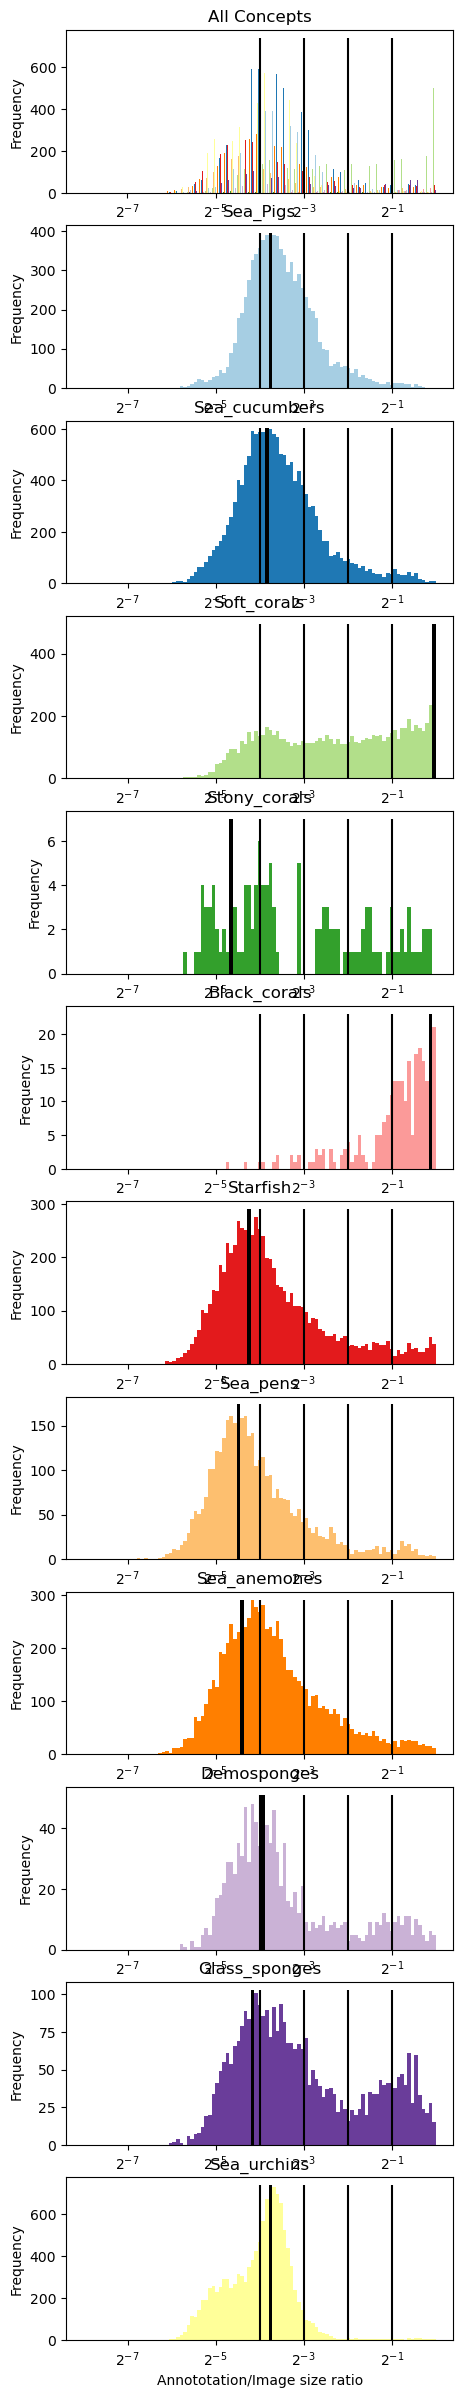

In [124]:
concepts = list(ann_data["super_concept"].unique())
fig, axs = plt.subplots(12, 1, figsize=(5,  30))
colors = plt.colormaps.get("Paired").colors
frequencies = [ann_data[ann_data["super_concept"]==cpt]["ratio"] for cpt in concepts]
mid_points = {}

for i, (cpt, freq) in enumerate(zip(concepts, frequencies)):
    ax = axs[i+1]
    c = colors[i]
    bins, _, patches = ax.hist(freq, bins=logbins, color=c)
    ax.vlines([2**-i for i in range(1, 5)], ymin=0, ymax=max(bins), color="k")
    ax.set_xscale(plt.matplotlib.scale.LogScale(ax.xaxis, base=2))
    
    max_bin = np.argmax(bins)
    plt.setp(patches[max_bin], "facecolor", "k")
    mid_points[cpt] = logbins[max_bin]

    
    ax.set_title(cpt)
    ax.set_xlabel("Annototation/Image size ratio")
    ax.set_ylabel("Frequency")
    
    #axs[0].hist(ann_data[ann_data["super_concept"]==cpt]["ratio"], bins=logbins, color=(c[0], c[1], c[2], 0.33))

bins, _, _ = axs[0].hist(frequencies, bins=logbins, color=colors[:11])
axs[0].set_xscale(plt.matplotlib.scale.LogScale(ax.xaxis, base=2))
axs[0].vlines([2**-i for i in range(1, 5)], ymin=min([min(bin) for bin in bins]), ymax=max([max(bin) for bin in bins]), color="k")
axs[0].set_xscale(plt.matplotlib.scale.LogScale(ax.xaxis, base=2))
axs[0].set_title("All Concepts")
axs[0].set_xlabel("Annototation/Image size ratio")
axs[0].set_ylabel("Frequency")
    

In [90]:
print(ann_data[ann_data["ratio"] < 2**-4]["uuid"].count())
print(ann_data[(2**-4 <= ann_data["ratio"]) & (2**-2 >= ann_data["ratio"]) ]["uuid"].count())

24966
33606


In [120]:
mid_points

{'Sea_Pigs': 0.07189425006063148,
 'Sea_cucumbers': 0.06797801858469948,
 'Soft_corals': 0.945527890302364,
 'Stony_corals': 0.03882504247417189,
 'Black_corals': 0.8940229913396391,
 'Starfish': 0.05137362610193099,
 'Sea_pens': 0.043427342305811335,
 'Sea_anemones': 0.045929202883612456,
 'Demosponges': 0.06427511249932576,
 'Glass_sponges': 0.05433327417290945,
 'Sea_urchins': 0.07189425006063148}

7 out of the 11 superclasses showed a bell-shaped distribution. For these groups, I arbitrarily chose the maxima of the distribution to divide the annotations into two groups.

In [127]:
splits = {}
splits["Sea_Pigs"] = [mid_points["Sea_Pigs"]]
splits["Sea_cucumbers"] = [mid_points["Sea_cucumbers"]]
splits["Starfish"] = [mid_points["Starfish"]]
splits["Sea_pens"] = [mid_points["Sea_pens"]]
splits["Sea_anemones"] = [mid_points["Sea_anemones"]]
splits["Demosponges"] = [mid_points["Demosponges"]]
splits["Sea_urchins"] = [mid_points["Sea_urchins"]]

Glass sponges showed a distrinct bimodal distribution. I chose to split it by the miminum between the two maxima.

In [128]:
splits["Glass_sponges"] = [0.25]

Soft corals showed a distinct distribution as the dataset contains a large number of closeup shots of soft corals. I decided to distinguish these closeup shots from the rest of the data. 

In [132]:
splits["Soft_corals"] = [0.5]

We have too few samples of black corals and stony corals to produce a continuous distribution. I decided against splitting these classes as a result.

In [133]:
splits["Stony_corals"] = []
splits["Black_corals"] = []

In [143]:
def get_split_category(row):
    ratio = row["ratio"]
    key = row["super_concept"]
    bins = splits[key]
    return np.digitize(ratio, bins)

ann_data["subclass"] = ann_data.apply(get_split_category, axis=1)

In [147]:
ann_data

,uuid,super_concept,specific_concept,index,img_w,img_h,ann_x,ann_y,ann_w,ann_h,img_dim,ann_dim,ratio,subclass
0,d55444fe-3a00-4ac3-92ee-fecce39bd878,Sea_Pigs,Elpidiidae,0,1600,1040,319,282,588,520,1289.96124,552.955694,0.428661,1
1,1cf425f2-409d-41d8-921a-a54d147c84be,Sea_Pigs,Elpidiidae,0,1600,1040,439,233,958,538,1289.96124,717.916430,0.556541,1
2,6237be4e-cdda-48cf-9545-2d12ce6de1ad,Sea_Pigs,Elpidiidae,0,1600,1040,809,282,714,560,1289.96124,632.329028,0.490192,1
3,91c29d6f-af56-4122-a7dc-0dc7451a6a22,Sea_Pigs,Elpidiidae,0,1600,1040,0,140,1000,750,1289.96124,866.025404,0.671358,1
4,ed1487e0-d8a9-4298-b98f-c2730d39588a,Sea_Pigs,Elpidiidae,0,1600,1040,11,183,1588,793,1289.96124,1122.178239,0.869932,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67107,911ed885-d1fb-498b-a472-9c95bb5409bb,Sea_urchins,Strongylocentrotus fragilis,0,1920,1080,1181,961,24,35,1440.00000,28.982753,0.020127,0
67108,911ed885-d1fb-498b-a472-9c95bb5409bb,Sea_urchins,Strongylocentrotus fragilis,1,1920,1080,1171,1004,26,32,1440.00000,28.844410,0.020031,0
67109,911ed885-d1fb-498b-a472-9c95bb5409bb,Sea_urchins,Strongylocentrotus fragilis,2,1920,1080,1070,975,30,33,1440.00000,31.464265,0.021850,0
67110,911ed885-d1fb-498b-a472-9c95bb5409bb,Sea_urchins,Strongylocentrotus fragilis,3,1920,1080,1110,888,33,37,1440.00000,34.942810,0.024266,0


In [148]:
splits

{'Sea_Pigs': [0.07189425006063148],
 'Sea_cucumbers': [0.06797801858469948],
 'Starfish': [0.05137362610193099],
 'Sea_pens': [0.043427342305811335],
 'Sea_anemones': [0.045929202883612456],
 'Demosponges': [0.06427511249932576],
 'Sea_urchins': [0.07189425006063148],
 'Glass_sponges': [0.25],
 'Soft_corals': [0.5],
 'Stony_corals': [],
 'Black_corals': []}

In [96]:
ann_data[["ratio", "super_concept", "cat"]].groupby(["super_concept", "cat"]).count()

ratio
super_concept cat       
Black_corals  0        2
              1       10
              2       20
              3      229
Demosponges   0      425
              1      355
              2      102
              3      175
Glass_sponges 0     1018
              1      963
              2      468
              3      842
Sea_Pigs      0     2262
              1     4194
              2     1465
              3      383
Sea_anemones  0     3621
              1     2485
              2     1094
              3      714
Sea_cucumbers 0     5076
              1     6324
              2     2335
              3      978
Sea_pens      0     2374
              1      901
              2      344
              3      236
Sea_urchins   0     5283
              1     6176
              2      494
              3      139
Soft_corals   0     1312
              1     1623
              2     1475
              3     3990
Starfish      0     3548
              1     1928
              2      801
              3      789
Stony_corals  0       54
              1       23
              2       17
              3       36